# Семинар 7 - Композиции алгоритмов

## Bias-Variance decomposition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def true_dep(x):
    return np.cos((x - 0.2)**2) + 0.2 / (1 + 50 * (x - 0.3)**2)

x_true = np.linspace(0, 1, 100)
y_true = true_dep(x_true)

def generate_n_datasets(num_datasets, dataset_length, noise_power=0.02):
    shape = (num_datasets, dataset_length, 1)
    x = np.random.uniform(size=shape)
    y = true_dep(x) + np.random.normal(scale=noise_power, size=shape)
    return x, y

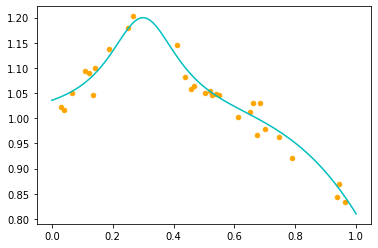

In [ ]:
x, y = generate_n_datasets(1, 30)
plt.scatter(x.squeeze(), y.squeeze(), s=20, c='orange')
plt.plot(x_true, y_true, c='c', linewidth=1.5);

In [ ]:
from copy import deepcopy
from tqdm import tqdm, trange

In [ ]:
def calc_bias2_variance(model, datasets_X, datasets_y):
    preds = []
    for X, y in tqdm(zip(datasets_X, datasets_y), total=len(datasets_X)):
        m = deepcopy(model)
        m.fit(X, y)
        preds.append(m.predict(x_true[:,np.newaxis]).squeeze())
    preds = np.array(preds)
    mean_pred = preds.mean(axis=0)
    bias2 = (y_true - mean_pred)**2
    variance = ((preds - mean_pred[np.newaxis,...])**2).mean(axis=0)

    return bias2, variance, preds

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

As you can see, we are using the `Pipeline` once again to both preprocess the feature space and fit the model at once.

In [ ]:
MAX_POWER = 6
powers = np.arange(1, MAX_POWER+1)

bias2, variance, preds = [], [], []
for p in powers:
    model = Pipeline([
      ('poly', PolynomialFeatures(degree=p)),
      ('linear', LinearRegression())
    ])

    b2, v, p = calc_bias2_variance(model, *generate_n_datasets(1000, 20))
    bias2.append(b2)
    variance.append(v)
    preds.append(p)

bias2 = np.array(bias2)
variance = np.array(variance)

100%|██████████| 1000/1000 [00:01<00:00, 820.73it/s]


6it [00:00,  6.79it/s]


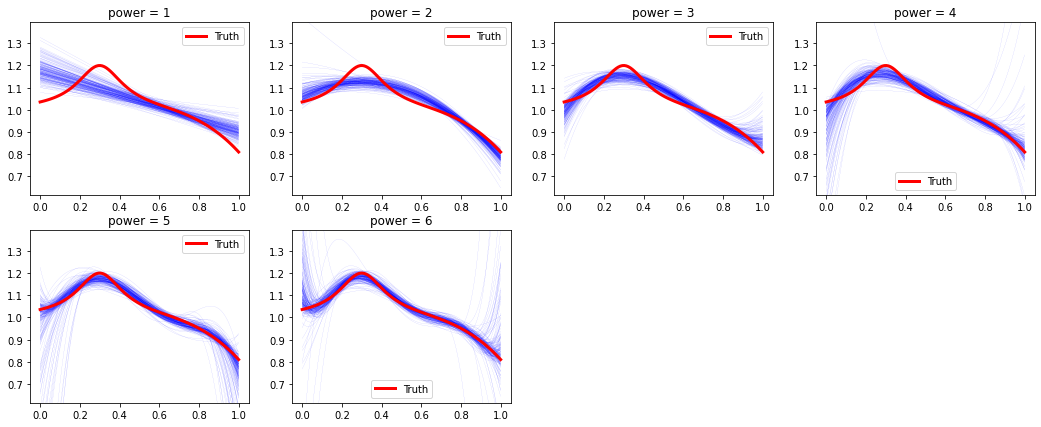

In [ ]:
ncols = 4
nrows = int(np.ceil(len(powers) / ncols))

plt.figure(figsize=(18, 3.5 * nrows))

yrange = y_true.max() - y_true.min()

for i, (pred, pow) in tqdm(enumerate(zip(preds, powers), 1)):
    plt.subplot(nrows, ncols, i)
    for p in pred[np.random.choice(len(pred), size=200, replace=False)]:
        plt.plot(x_true, p, linewidth=0.05, c='b');
    plt.plot(x_true, y_true, linewidth=3, label='Truth', c='r')
    plt.ylim(y_true.min() - 0.5 * yrange, y_true.max() + 0.5 * yrange)
    plt.title('power = {}'.format(pow))
    plt.legend();

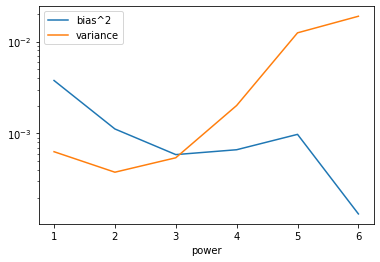

In [ ]:
plt.plot(powers, bias2.mean(axis=1), label='bias^2')
plt.plot(powers, variance.mean(axis=1), label='variance')
plt.legend()
plt.yscale('log')
plt.xlabel('power');

## Data

[Данные](https://drive.google.com/uc?export=download&id=1MClDyojQWLWxQ6NLXbB9D8zB6dMImf1P)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 4)})
import scipy.stats as st

import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
data = pd.read_csv('./gdrive/My Drive/Colab Notebooks/ML/семестр1/Семинар 7 - ensembles/data/flight_delays_train.csv')

In [ ]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Загрузим данные и проведем предобработки: 
data = pd.read_csv('./gdrive/My Drive/Colab Notebooks/ML/семестр1/Семинар 7 - ensembles/data/flight_delays_train.csv')
data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
data['Month'] = data['Month'].str.replace('c-', '').astype('int16')
data['DayofMonth'] = data['DayofMonth'].str.replace('c-', '').astype('int16')
data['DayOfWeek'] = data['DayOfWeek'].str.replace('c-', '').astype('int16')

data['UniqueCarrier'] = pd.factorize(data['UniqueCarrier'])[0]
data['Origin'] = pd.factorize(data['Origin'])[0]
data['Dest'] = pd.factorize(data['Dest'])[0]

# DepTime пусть будет более вещественным числом (так как 60 минут в часах)
data['DepTime_real'] = data['DepTime'].apply(lambda x: int(x/100)+((x/100-int(x/100))*100)/60)
data.drop('DepTime', axis=1, inplace=True)


x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values


data.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_real
0,8,21,7,0,0,0,732,0,19.566667
1,4,20,3,1,1,1,834,0,15.800000
2,9,2,5,2,2,2,416,0,14.366667
3,11,25,6,3,3,3,872,0,10.250000
4,10,7,6,4,4,4,423,1,18.466667


## Bootstrap
Посмотрим плотности распредления переменной "Время Вылета" для задержки менее 15 минут и более

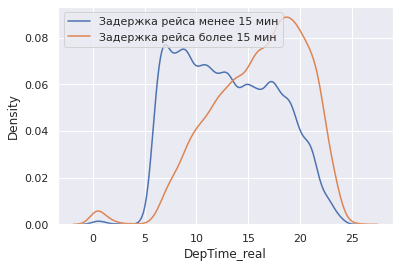

In [ ]:
sns.kdeplot(data[data['dep_delayed_15min'] == 0]['DepTime_real'], label='Задержка рейса менее 15 мин')
sns.kdeplot(data[data['dep_delayed_15min'] == 1]['DepTime_real'], label='Задержка рейса более 15 мин')
plt.legend()
plt.show()

In [ ]:
print('Среднее', data[data['dep_delayed_15min'] == 1]['DepTime_real'].mean())
print('Среднее', data[data['dep_delayed_15min'] == 0]['DepTime_real'].mean())

Среднее 16.002944934537595
Среднее 13.049982500781939


In [ ]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    # ваш код здесь
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# сохранение в отдельные numpy массивы данных по вылетам с задержками и без 
no_delayed = data[data['dep_delayed_15min'] == 0]['DepTime_real'].values
delayed = data[data['dep_delayed_15min'] == 1]['DepTime_real'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем 1000 выборок с помощью бутстрэпа и сразу считаем по каждой из них среднее
no_delayed_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(no_delayed, 1000)]
delayed_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(delayed, 1000)]

In [ ]:
#  выводим интервальную оценку среднего
print("Среднее время вылета по рейсам без задержек в интервале:",  stat_intervals(no_delayed_mean_scores, 0.05))
print("Среднее время вылета по рейсам с задержками в интервале:",  stat_intervals(delayed_mean_scores, 0.05))

Среднее время вылета по рейсам без задержек в интервале: [13.01780342 13.08034993]
Среднее время вылета по рейсам с задержками в интервале: [15.93900078 16.06732149]


## Bagging (Bootstrap aggregating)

In [ ]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
tree = DecisionTreeClassifier()

In [ ]:
# Посчитаем значение метрики accuracy на кроссвалидаци для дерева
np.mean(cross_val_score(tree, x, y, cv=3))

0.7283400211454566

In [ ]:
# Посчитаем значение метрики accuracy на кроссвалидаци для композиции деревьев построенной на бутстрап выборке
bag_of_trees = BaggingClassifier(tree)
np.mean(cross_val_score(bag_of_trees, x, y, cv=3))

0.8088399804619634

In [ ]:
# Для ограниченного числа признаков
tree = DecisionTreeClassifier(max_features=int(x.shape[1]**0.5))
bag_of_trees = BaggingClassifier(tree)
np.mean(cross_val_score(bag_of_trees, x, y, cv=3))

0.8104799965621302

## Случайный лес

### Как можно добавить случайности? 

Например: Ограничить кол-во признаков, по которым проводить разбиение

In [ ]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
forest = RandomForestClassifier(n_jobs=-1)
np.mean(cross_val_score(forest, x,y, cv=3, n_jobs=-1))

0.8188799941638344

### Что будет, если ограничить глубину построенных деревьев? 

In [ ]:
#Разделим выборку на обущающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, \
                                                    shuffle=True, random_state=21)

In [ ]:
train_score = []
test_score = []

for i in range(1,16):
    forest = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_depth=i, min_samples_leaf=50) # ваш код здесь
    forest.fit(x_train, y_train)
    train_score = np.append(train_score, accuracy_score(y_train, forest.predict(x_train)))
    test_score = np.append(test_score, accuracy_score(y_test, forest.predict(x_test)))

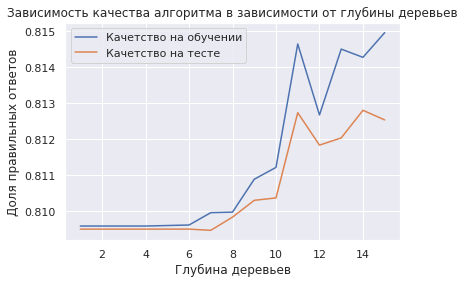

In [ ]:
plt.title('Зависимость качества алгоритма в зависимости от глубины деревьев')
plt.plot(range(1,16), train_score, label="Качетство на обучении")
plt.plot(range(1,16), test_score, label="Качетство на тесте")
plt.legend()
plt.ylabel('Доля правильных ответов')
plt.xlabel('Глубина деревьев')
plt.show()

## Out-of-bag error

На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, значит:  

__Вывод:__  
__Свойство:__ Можно вычислять Out-of-bag error и не проводить кроссвалидацию

In [ ]:
tree = DecisionTreeClassifier()
bag_of_trees = BaggingClassifier(tree, n_estimators=20, oob_score=True, n_jobs=-1)

In [ ]:
bag_of_trees.fit(x,y)
bag_of_trees.oob_score_

0.80366

## Важность признкаов
Одно из замечательных свойств, возможность посмотреть важность каждого признака, оценив вклад 

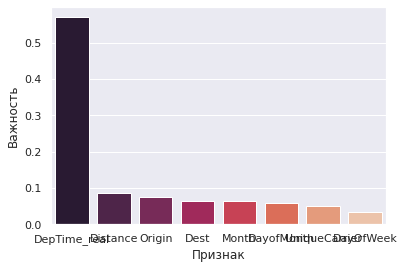

In [ ]:
feature_importances = pd.DataFrame(forest.feature_importances_, index=x_train.columns, columns=['Importance']
            ).sort_values('Importance', ascending=False)

sns.barplot(y=feature_importances['Importance'], x=feature_importances.index, palette="rocket")
plt.ylabel('Важность')
plt.xlabel('Признак')
plt.show()

## Ensembles of algorithms of different classes

### Определим базовые алгоритмы

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=21)

### Выберем алгоритмы

In [ ]:
f = plt.figure(figsize=(10, 9))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
df.corr()

### Применим подход Blending

In [ ]:
accuracy_score(blend_pred, y_test)

0.80872

### Применим подход Stacking

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 64 input units and 1 output unit. 
model.add_module('l1', nn.Linear(5, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module('l2', nn.Sigmoid())

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
df.values[100]

array([0, 0, 0, 0, 1])

In [ ]:
history = []

for i in range(10000):
    
    # sample 256 random predicts
    ix = np.random.randint(0, df.shape[0], 256)
    x_batch = torch.tensor(df.values[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_val[ix], dtype=torch.float32)
    
    # predict probabilities
    y_predicted = y_predicted = model(x_batch)[:, 0]
        
    # compute loss, just like before
    loss = F.binary_cross_entropy(y_predicted, y_batch)### YOUR CODE
    
    loss.backward()
    
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())
    
    if i % 1000 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

In [ ]:
model.eval()

Sequential(
  (l1): Linear(in_features=5, out_features=1, bias=True)
  (l2): Sigmoid()
)

In [ ]:
stacking_pred_proba = model(torch.tensor(df.values, dtype=torch.float32))

In [ ]:
stacking_pred = np.array(stacking_pred_proba.detach().numpy(), dtype=np.int)

In [ ]:
accuracy_score(stacking_pred, y_test)

0.80792

### Что будет, если среди наших алгоритмов будет 1 сильный